# Imports    

In [1]:
import os
import pandas as pd
import mne
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
import numpy as np

In [2]:

def get_channels(mne_data, channels_names):
    wanted_channels = mne.pick_channels(mne_data.info['ch_names'], include=channels_names)
    info_object = mne.pick_info(mne_data.info, wanted_channels)
    new_data = mne_data._data[wanted_channels, :]
    return mne.io.RawArray(new_data, info_object, verbose=False)


In [3]:
range_bounds = [0, 4, 8, 12, 30, 45]

def show_frequencies(psd, freqs):
    ranges_ratio = {}
    for p, f in zip(psd, freqs):
        if range_bounds[0] <= f <= range_bounds[1]:
            if 'delta' not in ranges_ratio:
                ranges_ratio['delta'] = []
            ranges_ratio['delta'].append(p) 
        elif range_bounds[1] < f <= range_bounds[2]:
            if 'theta' not in ranges_ratio:
                ranges_ratio['theta'] = []
            ranges_ratio['theta'].append(p)
        elif range_bounds[2] < f <= range_bounds[3]:
            if 'alpha' not in ranges_ratio:
                ranges_ratio['alpha'] = []
            ranges_ratio['alpha'].append(p)
        elif range_bounds[3] < f <= range_bounds[4]:
            if 'beta' not in ranges_ratio:
                ranges_ratio['beta'] = []
            ranges_ratio['beta'].append(p)
        else:
            if 'gamma' not in ranges_ratio:
                ranges_ratio['gamma'] = []
            ranges_ratio['gamma'].append(p)
    
    for freq_range, f in ranges_ratio.items():
        print(f'{freq_range}: {round(sum(f) / sum(psd) * 100, 3)}% of the total power')

def auc(x, t):
    diffs = np.ediff1d(t, to_begin=0)
    return np.abs(x * diffs).sum()

In [4]:
def csv_to_mne(df, sampling_rate=1000, montage_type='biosemi32', use_baseline=False, baseline=(None, 5)):
    montage = mne.channels.make_standard_montage(montage_type)
    ch_names = list(montage.get_positions()["ch_pos"].keys())
    types = ["eeg"] * 32
    mne_info = mne.create_info(
        ch_names=ch_names, ch_types=types, sfreq=sampling_rate, verbose=False
    )
    
    df = df.iloc[:, :-12]        

    data = mne.io.RawArray(df, mne_info, verbose=False)
    
    if use_baseline:
        data._data = mne.baseline.rescale(data._data, times=data.times, baseline=baseline)
    
    data.set_montage(montage)
    return data, ch_names 


In [5]:
# READ THE INITIAL DATA
df1 = pd.read_csv('first.csv', header=None)
df2 = pd.read_csv('second.csv', header=None)
# convert to mne data objects
mne1, ch_names= csv_to_mne(df1, use_baseline=True)
mne2, ch_names= csv_to_mne(df2, use_baseline=True)

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


In [6]:
def plot_sculls(mne_data, start=0, end=None, windows_size=0.5):
    if end is None:
        end = mne_data.times[-1]
        
    t = start
    while t < end:
         # first extract the data in that specific window
        data = mne_data.copy().crop(tmin=t, tmax=min(t + windows_size, end), verbose=False)
        # compute psd and plot the topomap        
        data_psd = data.compute_psd()
        
        fig = data_psd.plot_topomap(show_names=True, show=False)        
        # set the figure's size
        fig.set_figwidth(20)
        fig.set_figheight(20)
 
        # display the image
        plt.show()
        
        t += windows_size

Let's try to see visually which channels are activated the most. By the pictures below it seems that detectors on the Front Lobe are more activated. 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 sec)

Effective window size : 0.256 (s)


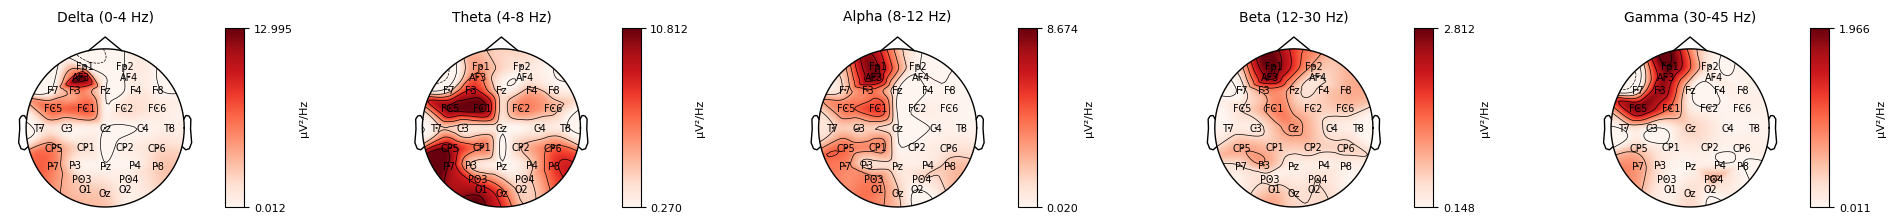

Effective window size : 0.256 (s)


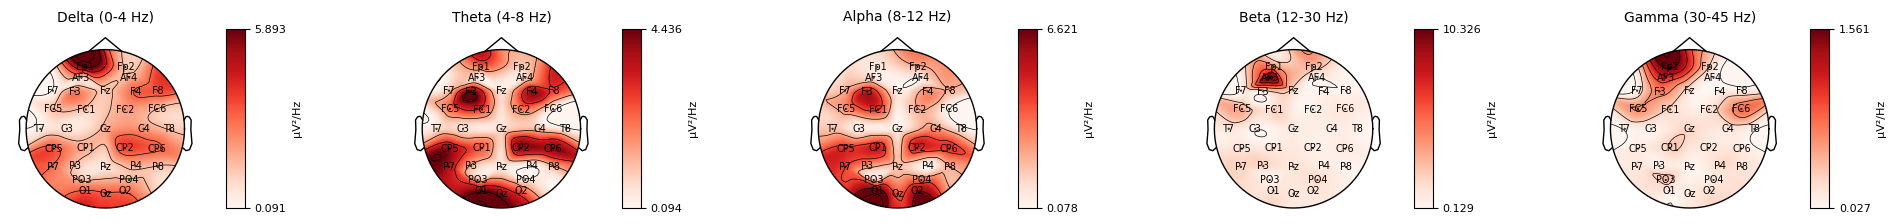

Effective window size : 0.256 (s)


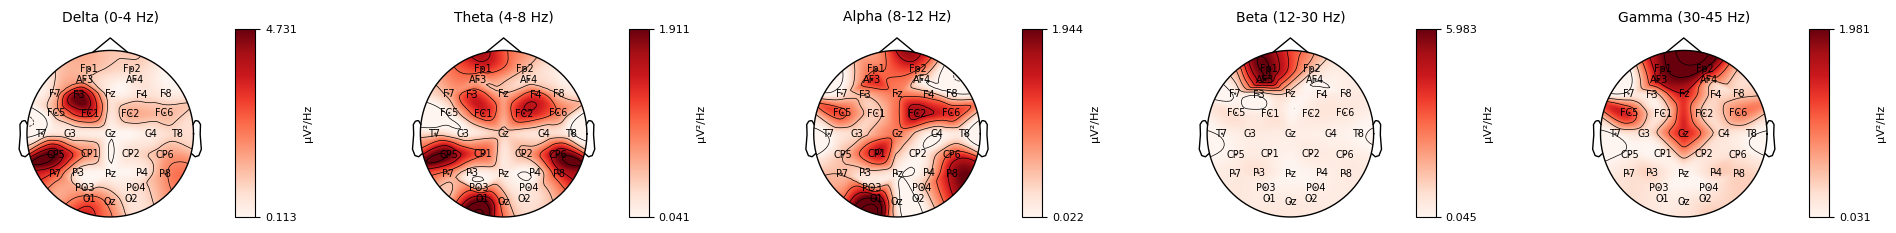

Effective window size : 0.256 (s)


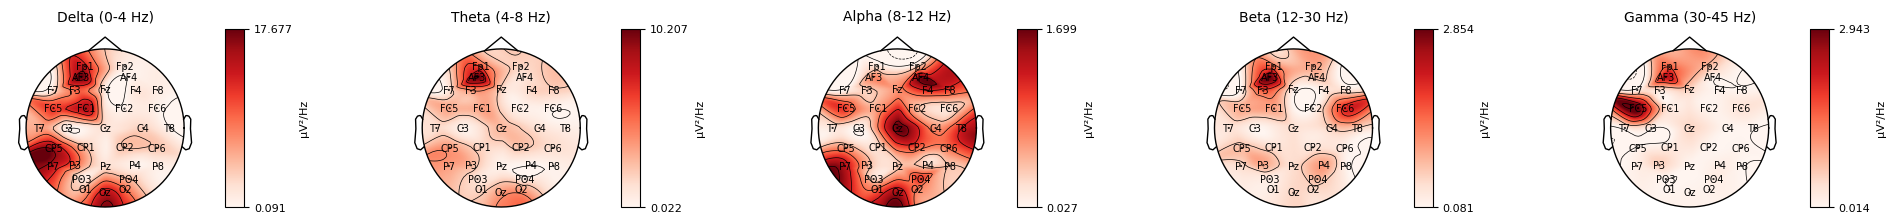

Effective window size : 0.256 (s)


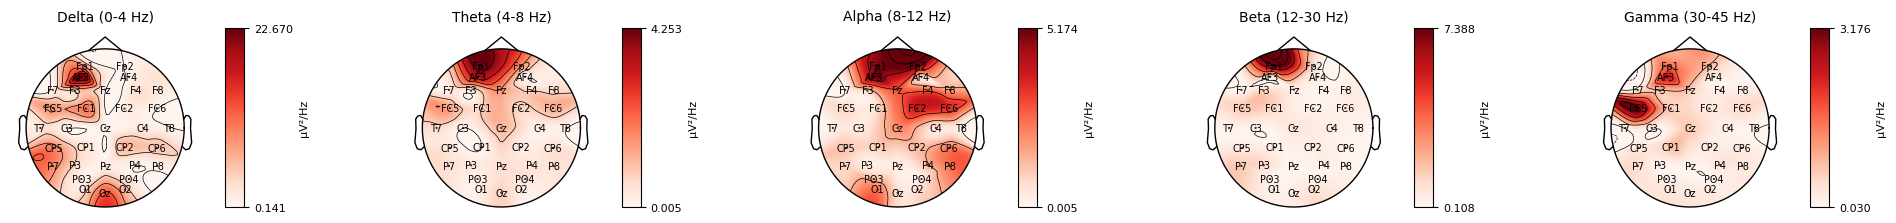

Effective window size : 0.256 (s)


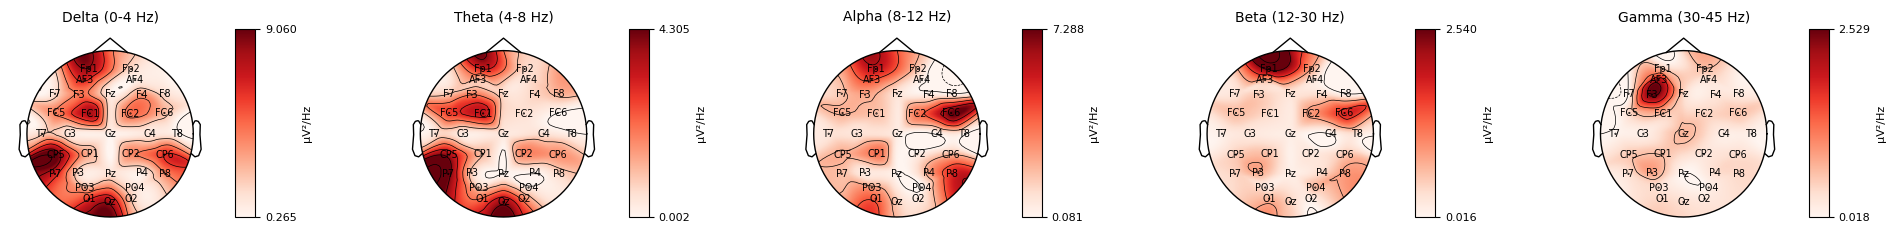

Effective window size : 0.256 (s)


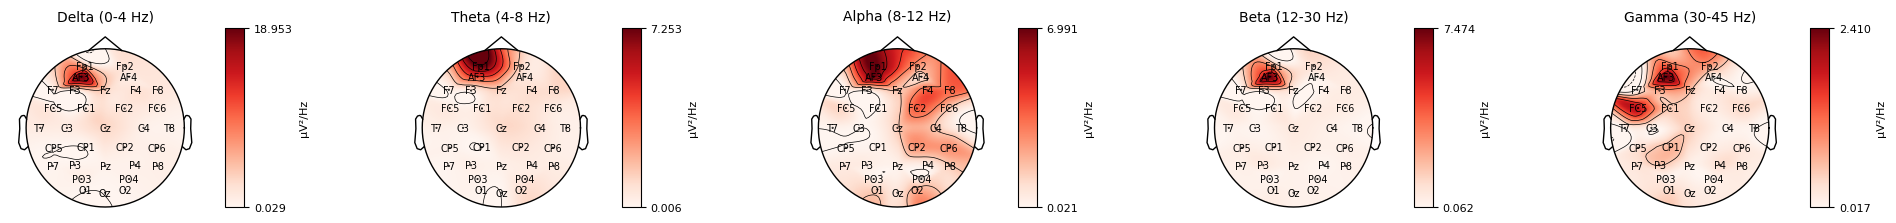

Effective window size : 0.256 (s)


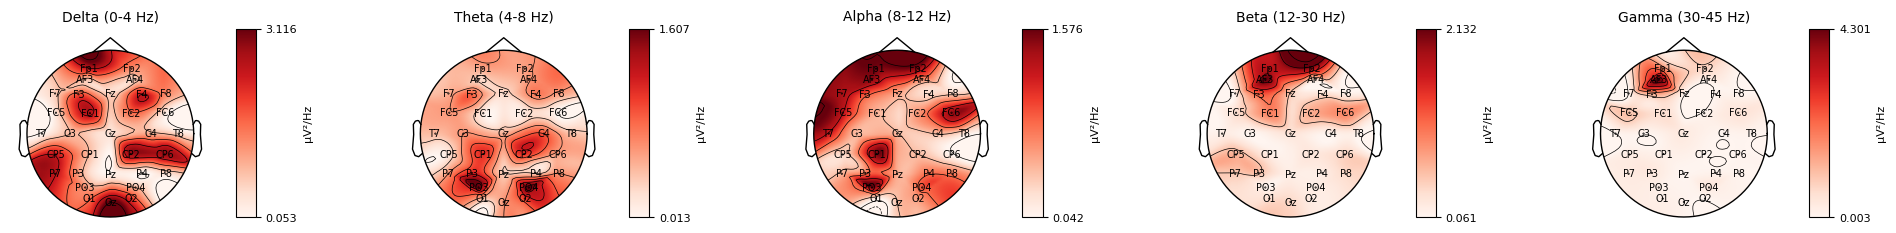

Effective window size : 0.256 (s)


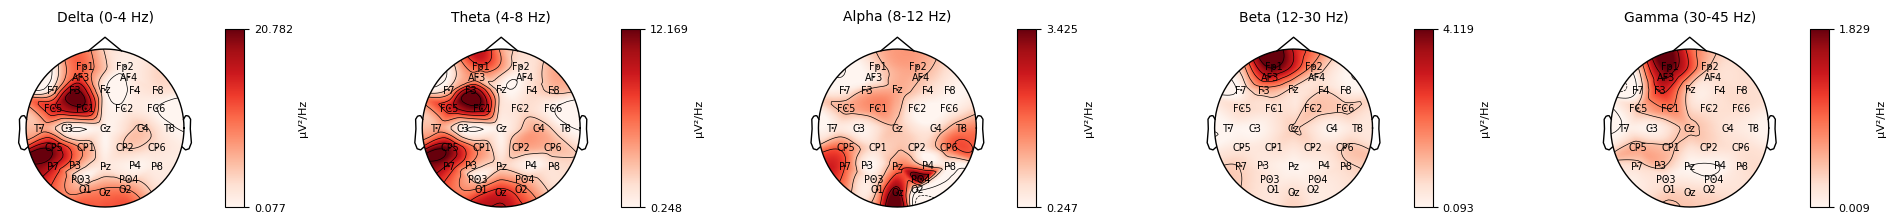

Effective window size : 0.256 (s)


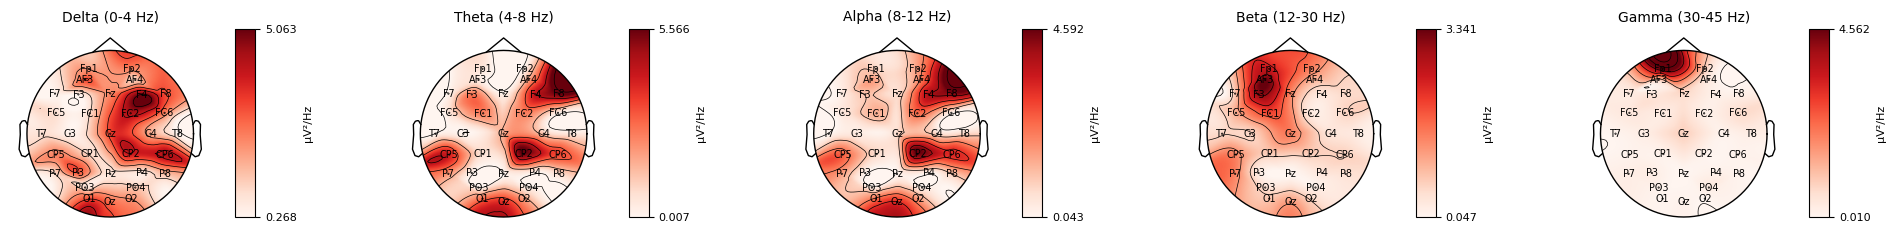

In [7]:
m1 = mne1.copy().filter(l_freq=1, h_freq=40)
plot_sculls(m1, start=5) # starting from the 5-th second (because the first 5 seconds are baseline)

Now let's try to quantify that observation. For that, I'll use area under curve. Indeed, values for AF3 and Fp1 happen to be the greatest

In [8]:
mne1cp = mne1.copy().crop(tmin=5)
pp = list(map(lambda x: auc(x, mne1cp.times), mne1cp._data))
pp = list(zip(ch_names, pp))
sorted(pp, key=lambda x: -x[1])

[('AF3', 6.393799443675941e-05),
 ('Fp1', 5.935785933795659e-05),
 ('F3', 4.115506793960008e-05),
 ('FC5', 3.994022344799757e-05),
 ('FC1', 3.824815161033129e-05),
 ('Fp2', 3.679868851441888e-05),
 ('CP5', 3.6306611063497885e-05),
 ('P7', 3.452503915667805e-05),
 ('Oz', 3.3491750128241574e-05),
 ('P3', 3.129362435273393e-05),
 ('Cz', 3.1080391531496495e-05),
 ('CP2', 3.096735897119782e-05),
 ('CP6', 3.0823089875772324e-05),
 ('F4', 3.0410828056044396e-05),
 ('FC6', 3.0233536401901893e-05),
 ('O1', 2.985546044749913e-05),
 ('FC2', 2.9553181839666744e-05),
 ('Fz', 2.9103584784352495e-05),
 ('O2', 2.846798588203844e-05),
 ('CP1', 2.8274488126118553e-05),
 ('F8', 2.7570001064997017e-05),
 ('P8', 2.546386170196847e-05),
 ('PO4', 2.4463282058928947e-05),
 ('C4', 2.390435977244499e-05),
 ('AF4', 2.3230496924116133e-05),
 ('PO3', 2.081894872386844e-05),
 ('T7', 2.0059386725249845e-05),
 ('P4', 2.001592021949995e-05),
 ('F7', 1.8667448326369243e-05),
 ('Pz', 1.6722689770317046e-05),
 ('T8', 1.5

They both show high activity in Beta frequencies.

In [9]:
channels = ['AF3', 'Fp1']
m1ch = get_channels(mne1cp, channels)
psd, freqs = mne.time_frequency.psd_array_multitaper(m1ch._data, sfreq=m1ch.info['sfreq'], fmin=1, fmax=45, verbose=False)

for i, ch_n in enumerate(channels):
    print("Channel " + ch_n)
    show_frequencies(psd[i], freqs)
    print()

Channel AF3
delta: 22.343% of the total power
theta: 15.861% of the total power
alpha: 6.338% of the total power
beta: 34.73% of the total power
gamma: 20.728% of the total power

Channel Fp1
delta: 20.623% of the total power
theta: 11.495% of the total power
alpha: 6.078% of the total power
beta: 39.94% of the total power
gamma: 21.864% of the total power



Same process for the second subject and we find that same channels AF3 and Fp1 are activated.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 sec)

Effective window size : 0.256 (s)


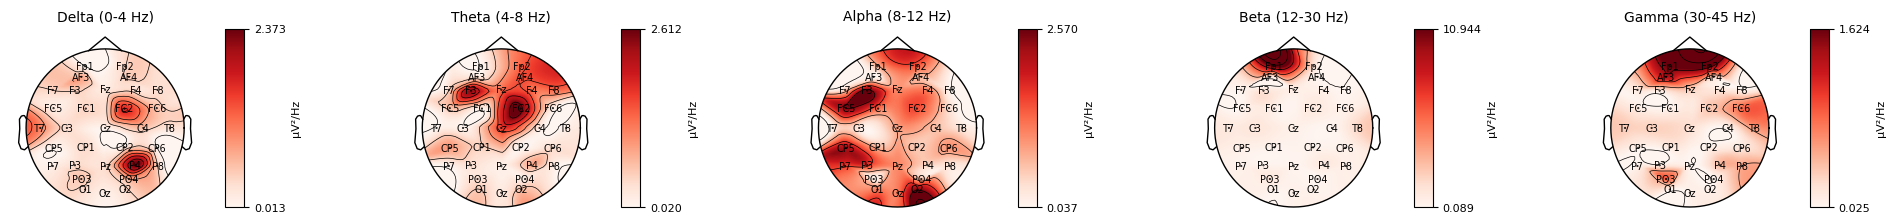

Effective window size : 0.256 (s)


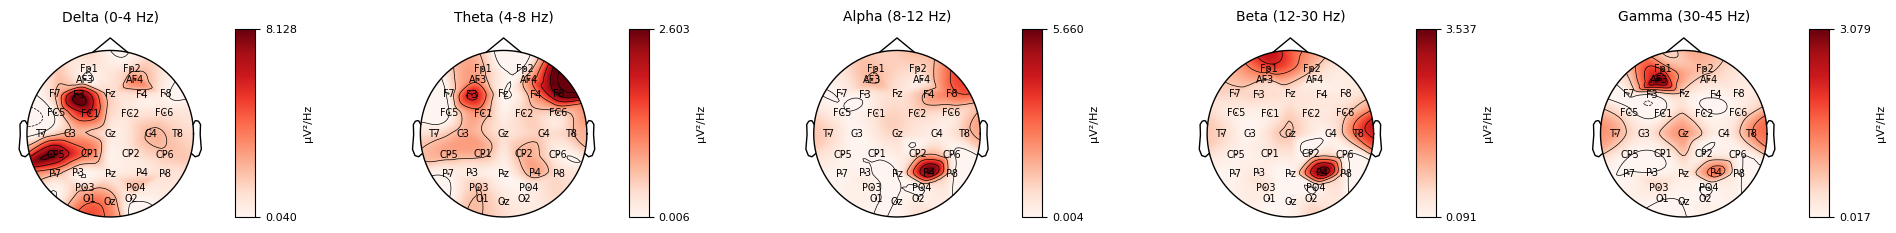

Effective window size : 0.256 (s)


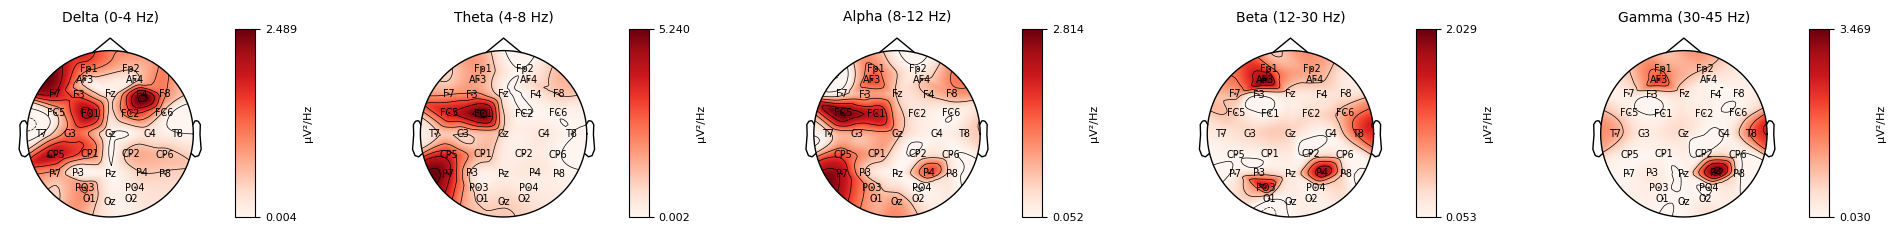

Effective window size : 0.256 (s)


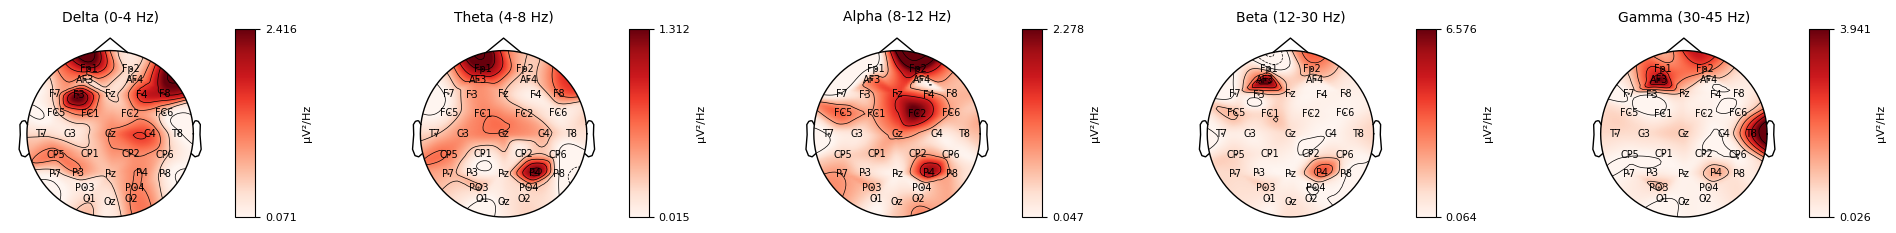

Effective window size : 0.256 (s)


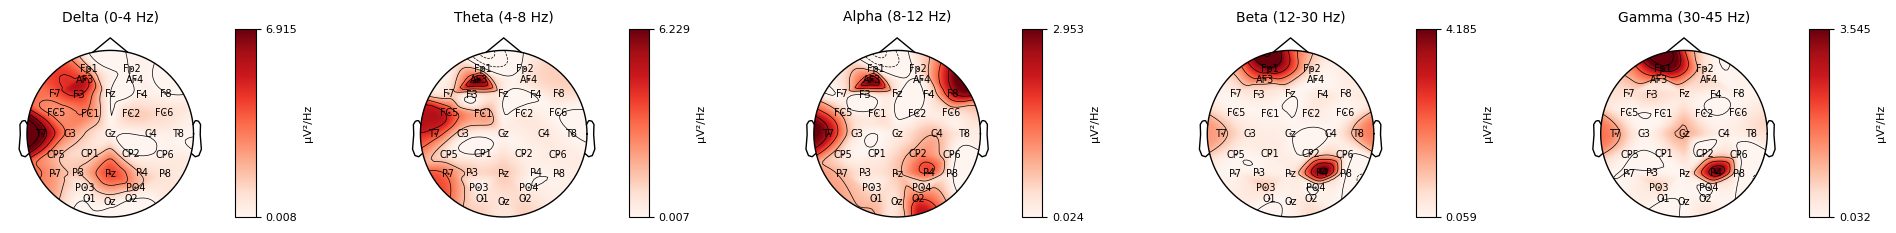

Effective window size : 0.256 (s)


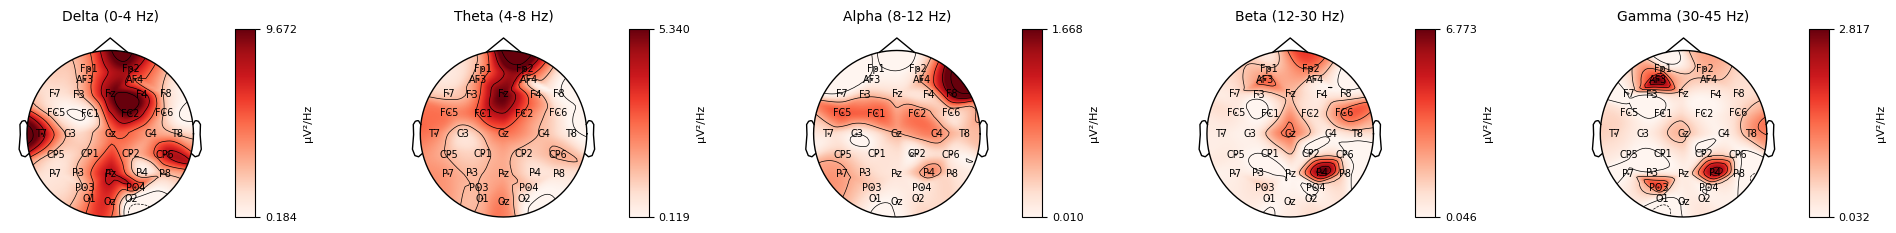

Effective window size : 0.256 (s)


In [ ]:
m2 = mne2.copy().filter(l_freq=1, h_freq=40)
plot_sculls(m2, start=5) # starting from the 5-th second (because the first 5 seconds are baseline)

In [ ]:
mne2cp = mne2.copy().crop(tmin=5)
pp = list(map(lambda x: auc(x, mne2cp.times), mne2cp._data))
pp = list(zip(ch_names, pp))
sorted(pp, key=lambda x: -x[1])

In [ ]:
channels = ['AF3', 'Fp1']
m2ch = get_channels(mne2cp, channels)
psd, freqs = mne.time_frequency.psd_array_multitaper(m2ch._data, sfreq=m2ch.info['sfreq'], fmin=1, fmax=45, verbose=False)

for i, ch_n in enumerate(channels):
    print("Channel " + ch_n)
    show_frequencies(psd[i], freqs)
    print()

# Verify

To verify that two samples are the same, I'll use a t-test on averaged signals of acitivities between two subjects.

p-value is high and T-statistic value is close to 0, so the activities are indeed the same

In [ ]:
def make_sample(m_data, i=4000):
    data = m_data._data[:, :i]
    data = np.mean(data, axis=0).T
    sample = (data - np.mean(data)) / np.std(data)
    
    return sample

t_stat, p_value = ttest_ind(make_sample(mne1cp), make_sample(mne2cp))
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)
